In [22]:
import numpy as np
import matplotlib.pyplot as plt

from rfest import GLM, LNP, LNLN
from rfest import build_design_matrix
from rfest.utils import get_n_samples, split_data, fetch_data, uvec
from rfest.check import plot3d, plot_diagnostics

In [23]:
data_liu = fetch_data(4)

(Liu, et al., 2017) is already downloaded. To re-download the same file, please set `overwrite=False`.
Loading data...
Done.


In [24]:
dims = [20, 25, 25]
dt = 0.033
num_subunits = 4

In [37]:
dims = [20, 25, 25]
dt = 0.033
num_subunits = 4

n_samples = get_n_samples(180, dt) # 20 mins of the full dataset

X = data_liu['train']['X'][:n_samples]
y = data_liu['train']['y'][:n_samples]
# X = build_design_matrix(X[:n_samples], dims[0])
# y = y[:n_samples]

(X_train, y_train), (X_dev, y_dev), (X_test, y_test) = split_data(X, y, dt, frac_train=0.989, frac_dev=0.011)

SUMMARY
               N    Minutes   Fraction
Total     327273      180.0        1.0
Train     323673     178.02      0.989
Dev         3600       1.98      0.011
Test           0        0.0        0.0


In [59]:
minutes = np.array([1, 2, 4, 8, 16, 32, 64])
n_samples_all = [get_n_samples(minute, dt) for minute in minutes]

In [56]:
import time
dfts = np.arange(6, 11+1, 1)
dfss = np.arange(8, 11+1, 1)

len(dfts), len(dfss)

(6, 4)

In [60]:
def build_model(df):
    
    m = GLM(distr='poisson', output_nonlinearity='softplus')
    m.add_design_matrix(X_train_sub, dims=dims, df=df, smooth='cr', filter_nonlinearity='softplus', name='stimulus') # light stimulus
    m.add_design_matrix(X_dev, dims=dims, name='stimulus', kind='dev')
    m.initialize({'train': y_train_sub, 'dev': y_dev}, num_subunits=1, dt=dt, method='mle', random_seed=2046, compute_ci=False)
    
    return m

In [64]:
results_all = {}
heatmaps = {}
for idx, n_samples in enumerate(n_samples_all[:]):
    print('n_samples=', n_samples)
    X_train_sub = X_train[:n_samples]
    y_train_sub = y_train[:n_samples]
    
    results_all[idx] = {}
    heatmaps[idx] = np.zeros([len(dfts), len(dfss)])
    i = 0
    for ii, dft in enumerate(dfts):
        for jj, dfs in enumerate(dfss):
            df = [dft, dfs, dfs]
            time_start= time.time()
            m = build_model(df)
            time_elapsed = time.time() - time_start
            metric_dev = m._score(m.y['dev'], m.forwardpass(m.p['mle'], 'dev'), 'corrcoef')

            heatmaps[idx][ii, jj] = metric_dev

            results_all[idx][i] = {'df': df, 'metric': metric_dev, 'time': time_elapsed}
            print(results_all[idx][i])
            i+= 1
    

{'df': [6, 8, 8], 'metric': 0.05830952795001026, 'time': 0.7185831069946289}
{'df': [6, 9, 9], 'metric': 0.03431253858592156, 'time': 0.6407639980316162}
{'df': [6, 10, 10], 'metric': 0.019855472745992656, 'time': 0.7418670654296875}
{'df': [6, 11, 11], 'metric': 0.01219432424582994, 'time': 0.8570640087127686}
{'df': [7, 8, 8], 'metric': 0.05500540085124672, 'time': 0.612962007522583}
{'df': [7, 9, 9], 'metric': 0.020047270382297293, 'time': 0.6965951919555664}
{'df': [7, 10, 10], 'metric': 0.0068891356837969325, 'time': 0.8152940273284912}
{'df': [7, 11, 11], 'metric': 0.009351074863683225, 'time': 0.9280149936676025}
{'df': [8, 8, 8], 'metric': 0.05961041060260548, 'time': 0.6783719062805176}
{'df': [8, 9, 9], 'metric': 0.03865784731040587, 'time': 0.7662839889526367}
{'df': [8, 10, 10], 'metric': 0.04079904780997968, 'time': 0.8549497127532959}
{'df': [8, 11, 11], 'metric': -0.009671995865835996, 'time': 1.0100009441375732}
{'df': [9, 8, 8], 'metric': 0.05179824716694217, 'time': 0

In [112]:
total_time_elapsed = 0
for key in results_all:
    results = results_all[key]
    time_elapsed = np.sum([results[i]['time'] for i in range(len(results))])
    total_time_elapsed += time_elapsed
    print(key,  time_elapsed / 60)
    
print(total_time_elapsed / 60)

0 0.35914117097854614
1 0.47999449968338015
2 0.7925921837488811
3 1.3633397698402405
4 2.4474962949752808
5 6.365899356206258
6 16.552570462226868
28.361033737659454


In [77]:
def plot_heatmap(heatmap):
    max_y, max_x = np.where(heatmap.max() == heatmap)
    fig, ax = plt.subplots(figsize=(6,6))
    cbar = ax.imshow(heatmap, cmap=plt.cm.Blues, origin='lower', vmax=vmax, vmin=0)
    ax.set_xticklabels(np.hstack([0, dfss]), fontsize=12)
    ax.set_yticklabels(np.hstack([0, dfts]), fontsize=12)
    ax.scatter(max_x, max_y, color='red', marker='x', s=80)
    ax.set_xlabel('$df$ for Spatial Dimenstion', fontsize=14)
    ax.set_ylabel('$df$ for Temporal Dimenstion', fontsize=14)
    fig.colorbar(cbar)


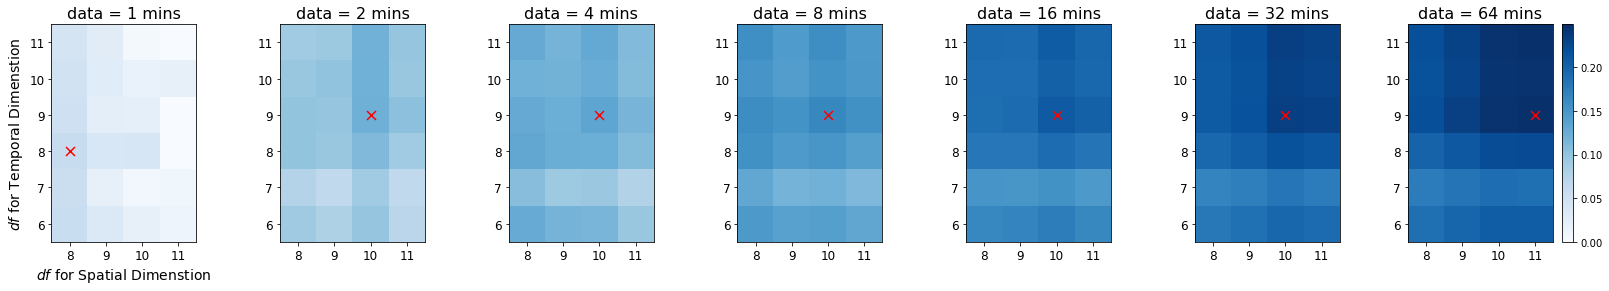

In [101]:
vmax = np.max([heatmaps[i] for i in range(7)])
fig, ax = plt.subplots(1, 7, figsize=(28, 4))
ax = ax.flatten()

for i in range(7):
    heatmap = heatmaps[i]
    max_y, max_x = np.where(heatmap.max() == heatmap)
    cbar = ax[i].imshow(heatmap, cmap=plt.cm.Blues, origin='lower', vmax=vmax, vmin=0)
    ax[i].set_xticks(np.arange(-0, len(dfss), 1))
    ax[i].set_xticklabels(np.hstack([dfss]), fontsize=12)
    ax[i].set_yticklabels(np.hstack([0, dfts]), fontsize=12)
    ax[i].scatter(max_x, max_y, color='red', marker='x', s=80)
    if i == 0:
        ax[i].set_xlabel('$df$ for Spatial Dimenstion', fontsize=14)
        ax[i].set_ylabel('$df$ for Temporal Dimenstion', fontsize=14)
    if i == 6:
        fig.colorbar(cbar)
        
    ax[i].set_title(f'data = {minutes[i]} mins', fontsize=16)

fig.savefig('figs/SupFigure-CV.pdf')

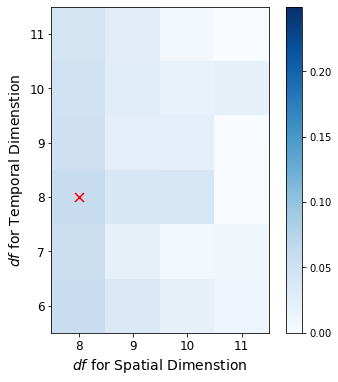

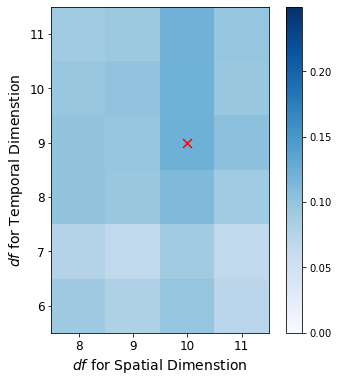

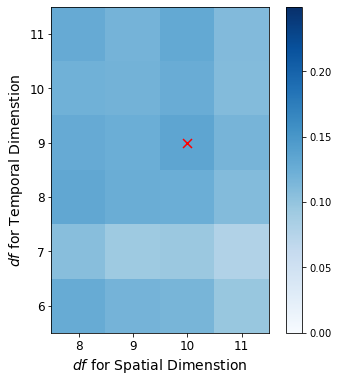

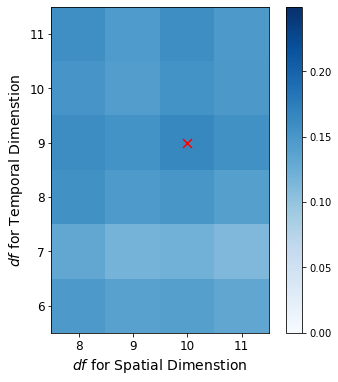

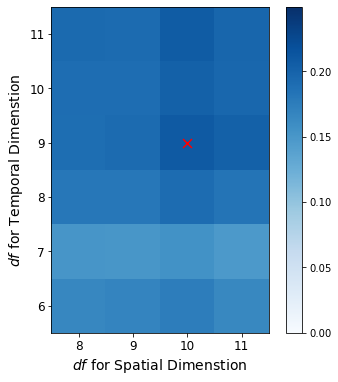

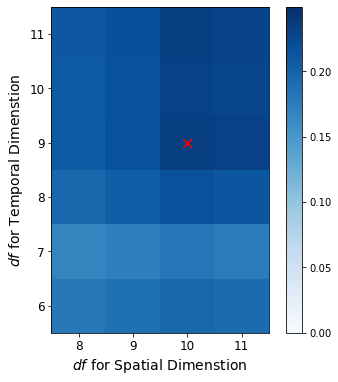

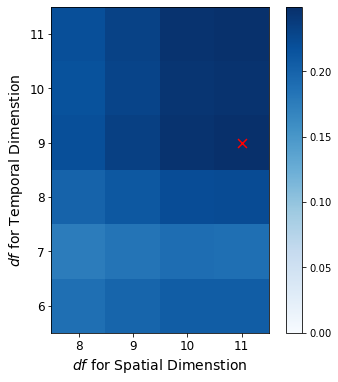

In [79]:
for i in range(7):
    plot_heatmap(heatmaps[i],)
    plt.show()

In [73]:
len(heatmaps)

7